In [2]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Unzip dataset
zip_ref = zipfile.ZipFile('political-social-media-posts.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

In [4]:
# Load in dataset with Latin-1 encoding
dataset = pd.read_csv('political_social_media.csv', encoding="ISO-8859-1")

In [5]:
# shape
print(dataset.shape)
# head
print(dataset.head(20))

(5000, 21)
     _unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0   766192484    False   finalized                   1      8/4/15 21:17   
1   766192485    False   finalized                   1      8/4/15 21:20   
2   766192486    False   finalized                   1      8/4/15 21:14   
3   766192487    False   finalized                   1      8/4/15 21:08   
4   766192488    False   finalized                   1      8/4/15 21:26   
5   766192489    False   finalized                   2      8/4/15 21:06   
6   766192490    False   finalized                   1      8/4/15 21:07   
7   766192491    False   finalized                   1      8/4/15 20:51   
8   766192492    False   finalized                   1      8/4/15 20:57   
9   766192493    False   finalized                   2      8/4/15 21:14   
10  766192494    False   finalized                   1      8/4/15 20:35   
11  766192495    False   finalized                   1      8/4/15 21:15   
1

In [6]:
# high-level descriptions of fields we're interested in
print(dataset.describe(include=[np.object])['message'])
print(dataset.describe(include=[np.object])['source'])
print(dataset.describe(include=[np.object])['bias'])

count       5000
unique         9
top       policy
freq        1411
Name: message, dtype: object
count         5000
unique           2
top       facebook
freq          2500
Name: source, dtype: object
count        5000
unique          2
top       neutral
freq         3689
Name: bias, dtype: object


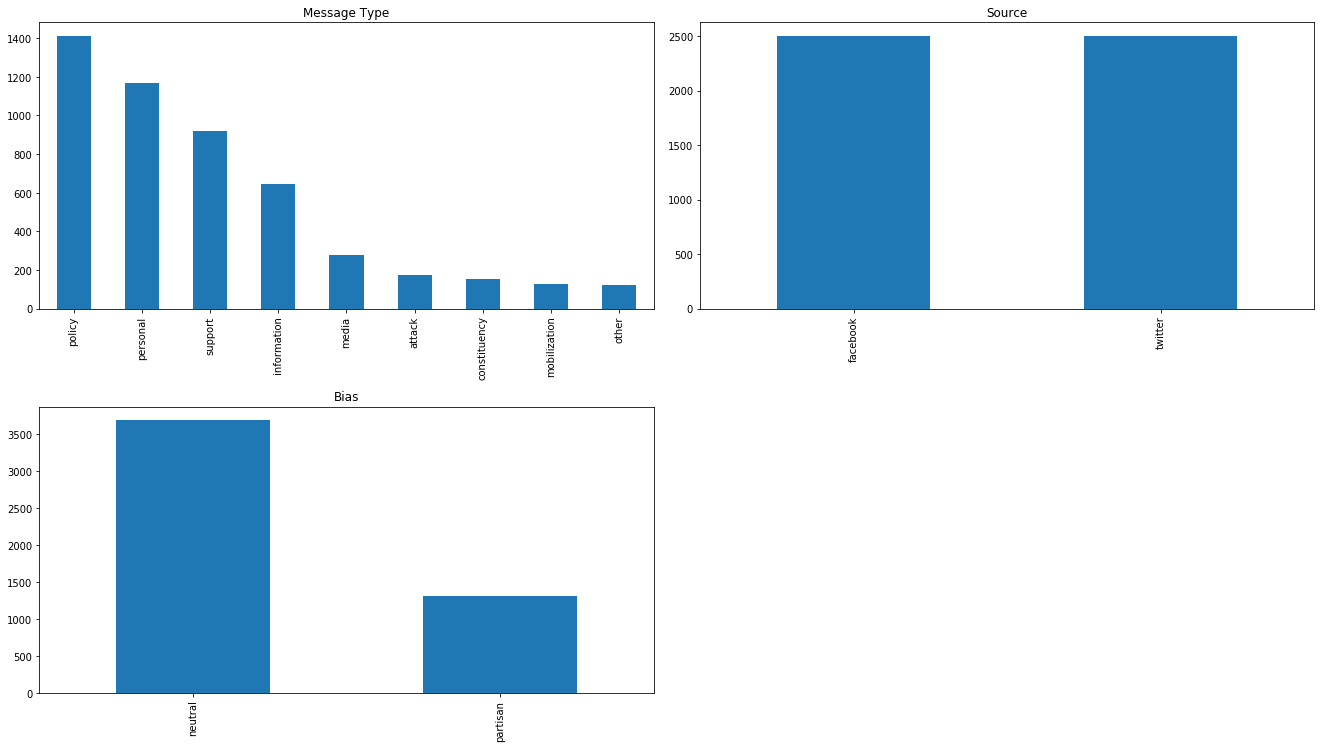

In [7]:
fig1 = plt.figure(1)
fig1.set_size_inches(18.5, 10.5)
plt.subplot(221)
plt.title('Message Type')
pd.value_counts(dataset['message']).plot.bar()
plt.subplot(222)
plt.title('Source')
pd.value_counts(dataset['source']).plot.bar()
plt.subplot(223)
plt.title('Bias')
pd.value_counts(dataset['bias']).plot.bar()
plt.tight_layout()

In [8]:
neutral_messages = dataset[(dataset.bias == 'neutral')]
partisan_messages = dataset[(dataset.bias == 'partisan')]

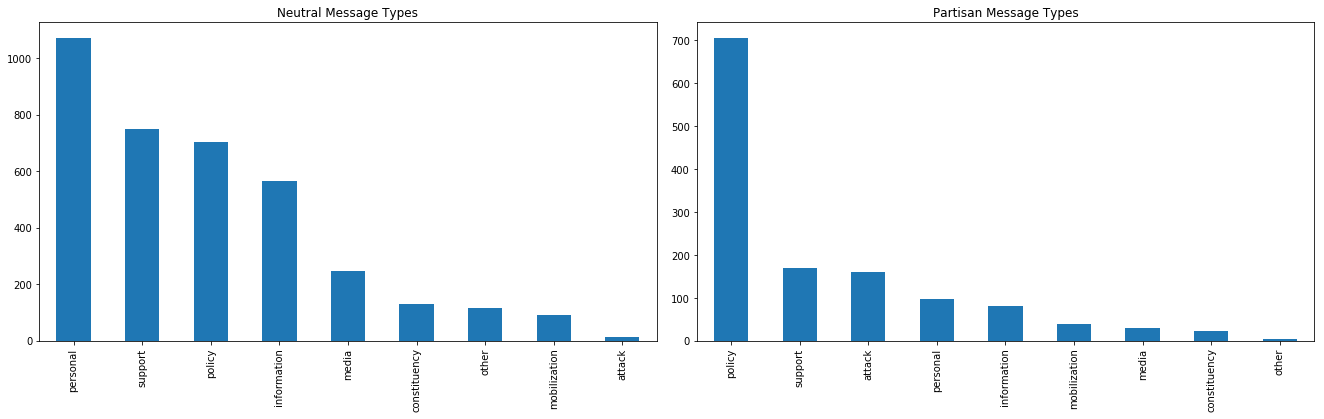

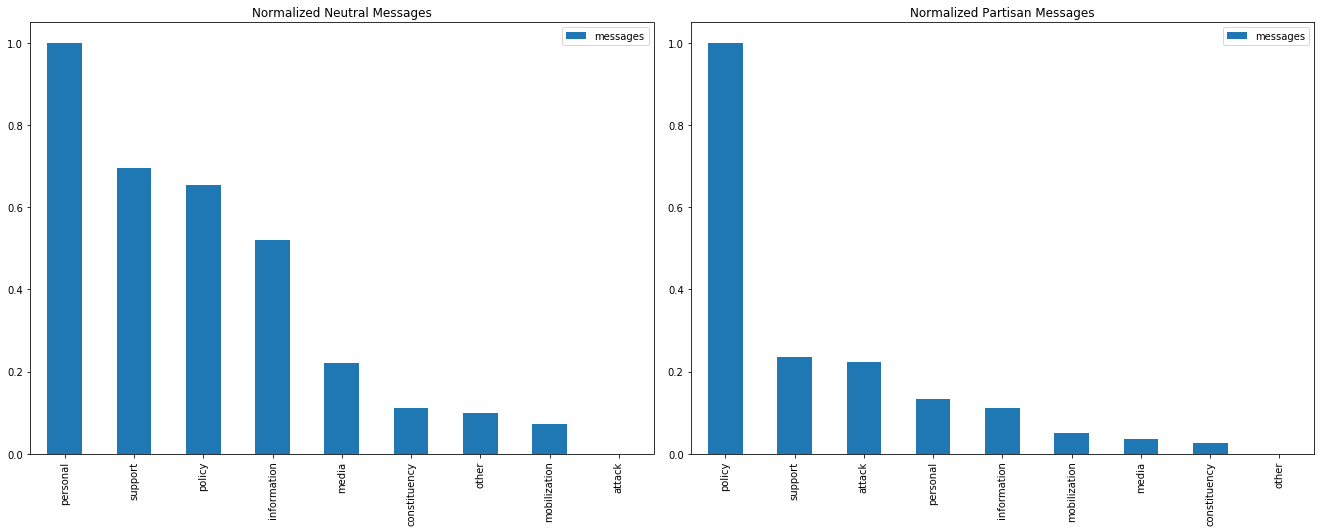

In [9]:
fig2 = plt.figure(2)

fig2.set_size_inches(18.5, 10.5)
plt.subplot(221)
plt.title('Neutral Message Types')
neutral_counts = pd.value_counts(neutral_messages['message'])
neutral_counts.plot.bar()
plt.subplot(222)
plt.title('Partisan Message Types')
partisan_counts = pd.value_counts(partisan_messages['message'])
partisan_counts.plot.bar()
plt.tight_layout()
#########

fig3, axes = plt.subplots(nrows=1, ncols=2)
fig3.set_size_inches(18.5, 7.5)
neutral_df = neutral_counts.to_frame(name="messages")
normalized_neutral_df = (neutral_df-neutral_df.min())/(neutral_df.max()-neutral_df.min())
normalized_neutral_df.plot(kind='bar', ax=axes[0], sharex=False, sharey=False, title="Normalized Neutral Messages")
partisan_df = partisan_counts.to_frame(name="messages")
normalized_partisan_df = (partisan_df-partisan_df.min())/(partisan_df.max()-partisan_df.min())
normalized_partisan_df.plot(ax=axes[1], kind='bar',sharex=False, sharey=False, title="Normalized Partisan Messages")
plt.tight_layout()

In [17]:
def one_hot_encoding(message):
    return 0 if message == "attack" else 1

attack_or_support_df = dataset[(dataset.message == 'attack') | (dataset.message == 'support')][['message','text']]
attack_or_support_df = attack_or_support_df.reset_index(drop=True)
attack_or_support_df['message'] = attack_or_support_df['message'].apply(one_hot_encoding)
attack_or_support_df

,message,text
0,0,VIDEO - #Obamacare: Full of Higher Costs and ...
1,1,Please join me today in remembering our fallen...
2,1,Great op-ed by Pres. Clinton about signing #FM...
3,0,The President doesnÛªt get to just decide he ...
4,1,"For health coverage starting Jan. 1st, you mus..."
5,1,The House will vote this week to #DefundObamac...
6,1,Tks to Margaret 4 joining me in DC to share su...
7,1,A great look back at at Idaho Native American ...
8,1,This wkÛªs 1 min video is on how expanding Me...
9,0,Remember Bill? He and his friends are stuck on...


In [44]:
from keras.datasets import imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data()

17465344/17464789 [==============================] - 4s     


0